Necessary imports:

In [28]:
import csv
import requests
import json
import urllib.request
import os
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from nltk.corpus import stopwords
import pycountry
dutch_stopwords = stopwords.words("dutch")

# Court Case Scraper

### Config

In [20]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }


### Old Methods

Method to extract the text from the casefiles. Search the uitsprakenBaseURL with case ID to get the html file. 
Filter through the html file with BeautifulSoup and look for either class 'uitspraak' or 'conclusie' as the standard seems to switch between cases. 
Parse html file to textfile to get a clean text file. Replace \n and commas with empty strings.

In [4]:
def getCaseText(caseId):
    response = requests.get(uitsprakenBaseUrl + caseId)
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_content = soup.find("div", {"id": 'content'})
    uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    if soup_content.find('div', {'class': 'uitspraak'}) is not None:
        uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    elif soup_content.find('div', {'class': 'conclusie'}) is not None:
        uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
    uitspraak = uitspraak_html.get_text()
    uitspraak = uitspraak.replace(',', '')
    return uitspraak

Method to parse each case individually. Save case attributes to cases.csv and save each case text to a .txt file in /data/ folder and name it the case ID.

In [5]:
def parseCaseInfo(results):
    global cases_df
    for case in results:
        caseText = getCaseText(case['TitelEmphasis'])
        parsedId = case['TitelEmphasis'].replace(':', '-') # Case id's apparentlyl use ':'. We cannot save files with ':' in the name, so we replace them with '-'.
        f= open(save_text_location + parsedId + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
        f.write(caseText)
        case['Case ID'] = parsedId
        cases_df = cases_df.append(case, ignore_index = True)
        print('Processed case', case['Case ID'])
    cases_df.to_csv('cases3.csv', index=False)

Method to retrieve raw data from the backend. Backend url is at the top in the Config. files = complete request payload the backend expects to receive. 


In [ ]:
def queryUitspraak():
    print("Querying")
    files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":searchQuery,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }
    try:
        response = requests.post(baseUrl, json=files)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records!")
        parseCaseInfo(results)
    except urllib.error.HTTPError as err:
        print(err) 

queryUitspraak()

### Methods

Get cases from https://uitspraken.rechtspraak.nl/api/zoek.
Returns a collection of dictionaries.

In [3]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records found.")
        return results
    except urllib.error.HTTPError as err:
        print(err)   

Create a dataframe of all queried cases with the following columns: 
- Id
- Verdict date
- Publication date
- Verdict type
- Jurisdiction type

In [4]:
def create_cases_df(cases):
    cases_df = pd.DataFrame(columns = index)
    cases_df = pd.DataFrame(columns = index)
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True)
    cases_df.to_csv('./court case data/testdata.csv', index=False)
    return cases_df
            

Save the text of all cases from the dataframe to a .txt file located in /data folder. 

In [6]:
def save_case_text(df):
#     case_count = len(df)
    i = 1
    for case in df["id"]:
        try:
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            if soup_content.find('div', {'class': 'uitspraak'}) is not None:
                uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            elif soup_content.find('div', {'class': 'conclusie'}) is not None:
                uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
            uitspraak = uitspraak_html.get_text()
            uitspraak = uitspraak.replace(',', '')
            parsed_id = case.replace(":", "-")
            f= open(save_text_location + parsed_id + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
            f.write(uitspraak)
#             print(f"{i}/{case_count} {parsed_id}")
#             clear_output(wait=True)
#             i += 1
        except Exception as e:
            print(f"Error in saving. {e}")
    print("Finished")
            

### Create dataset

In [7]:
cases = get_cases(files)
cases_df = create_cases_df(cases)
# save_case_text(cases_df)


17981 records found.


In [329]:
%%time
save_case_text(cases_df)

Finished
CPU times: user 6.31 s, sys: 278 ms, total: 6.59 s
Wall time: 39.4 s


In [8]:
%%time
cases_df_1 = cases_df[:5000]
cases_df_2 = cases_df[5000:10000]
cases_df_3 = cases_df[10000:15000]
cases_df_4 = cases_df[15000:]

print(len(cases_df_1))
print(len(cases_df_2))

t1 = Thread(target=save_case_text ,args=(cases_df_1,))
t2 = Thread(target=save_case_text ,args=(cases_df_2,))
t3 = Thread(target=save_case_text ,args=(cases_df_3,))
t4 = Thread(target=save_case_text ,args=(cases_df_4,))


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

print("finished")

5000
5000
Finished
Finished
Finished
Finished
finished
CPU times: total: 13min 23s
Wall time: 26min 8s


### Create and clean full dataframe

Create:

In [2]:
dataPath = os.getcwd() + '/court case data/testdata/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=["id", "case text"])
cases_df = pd.read_csv('./court case data/testdata.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])


No file DS_Store


Clean:

In [3]:
total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_uncleaned += length
print(f"Total words in uncleaned dataset: {total_len_uncleaned}")

Total words in uncleaned dataset: 84910721


In [4]:
cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))
print("Done")

Done


In [5]:
total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


Original count: 84910721 
 Cleaned count: 50853053 
 Difference: 34057668
40.11% decrease


### Filter for trafficking keywords

In [35]:
print(f"Original case count: {len(cleaned_df)}")

trafficking_df = pd.DataFrame()
# trafficking_words = ["smokkel", "transport", "invoer", "import", "export", "uitvoer"]
trafficking_words = ["smokkel", "transport"]


for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    if any(x in curr["case text"] for x in trafficking_words):
        trafficking_df = trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(trafficking_df)} articles.")

Original case count: 17981
Filtered for trafficking:  2538 articles.


In [36]:
def get_links(df):
    link_list = []
    for i in range(len(df)):
        curr = df.iloc[i]
        link = complete_case_url + curr['id'].replace('-', ':')
        link_list.append(link)
    print(link_list)

In [37]:
get_links(trafficking_df)

['https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBZUT:2003:AH9598', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBAMS:2021:1756', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2020:78', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2020:82', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGEAC:2018:352', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2017:257', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:HR:2007:BA1113', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:PHR:2007:BA1113', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGEAC:2018:354', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:GHAMS:2018:2662', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBAMS:2017:9087', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBAMS:2017:9085', 'https://uitspraken.rechtspraak.nl/inziendocument?i

### TF-IDF

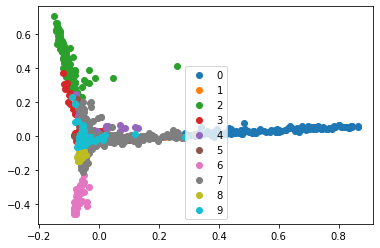

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

documents = trafficking_df["case text"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)

X = vectorizer.fit_transform(documents)
X = X.astype('float32')

true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [59]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(trafficking_df["K means cluster"].value_counts())

Top terms per cluster:
              0                      1                2                     3  \
0   slachtoffer                gerecht        container               heroïne   
1    benadeelde                  aruba       containers            maastricht   
2        geweld                curaçao        antwerpen               turkije   
3      aangever  opiumlandsverordening        ananassen                  2001   
4   aangeefster                   1960              ect       diacetylmorfine   
5           mes                     lt           lading              engeland   
6        letsel       landsverordening          terrein            brittannië   
7         hoofd                     gt             2020             container   
8       lichaam                   boot  containernummer               morfine   
9   prostitutie                   2020      vrachtwagen                   stk   
10          dna              kustwacht            schip                  2021   
11   

C:\Users\casbe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 

### 

# Dutch News Articles

### Import Data

In [61]:
nos_df = pd.read_csv('./NOS articles/dutch-news-articles.csv')
nos_df["datetime"] = pd.to_datetime(nos_df["datetime"])

In [62]:
print(nos_df["category"].unique())

['Buitenland' 'Binnenland' 'Politiek' 'Economie' 'Koningshuis'
 'Opmerkelijk' 'Tech' 'Cultuur & Media' 'Regionaal nieuws']


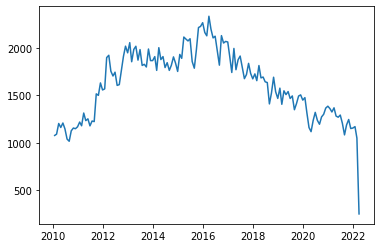

In [63]:
nos_date_plot = nos_df["datetime"].value_counts().resample("1M").sum()
plt.plot(nos_date_plot)

### Clean data

In [64]:
print(f"{len(nos_df)} articles")

word_count = 0
for i in range(len(nos_df)):
    curr = nos_df.iloc[i]
    word_count += len(curr["content"].split())
print(word_count)


237442 articles
58984150


In [65]:
cleaned_nos_df = nos_df.copy()
cleaned_nos_df['content'] = cleaned_nos_df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))


In [66]:
cleaned_word_count = 0
for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    cleaned_word_count += len(curr["content"].split())
print(cleaned_word_count)

34989557


In [67]:
print(f"Original count: {word_count} \n Cleaned count: {cleaned_word_count} \n Difference: {word_count - cleaned_word_count}")
print(f"{round((word_count - cleaned_word_count) / word_count * 100, 2)}% decrease")


Original count: 58984150 
 Cleaned count: 34989557 
 Difference: 23994593
40.68% decrease


### Filter articles for drugs and trafficking, and extract country

In [68]:
print(f"Original NOS dataframe contains {len(cleaned_nos_df)} articles.")

nos_drugs_df = pd.DataFrame()
drugs_words = ["drugs", "narcotica", "verdovende middelen"]

for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    if any(x in curr["content"] for x in drugs_words):
        nos_drugs_df = nos_drugs_df.append(curr)
        
print(f"Filtered for drugs: {len(nos_drugs_df)} articles")

Original NOS dataframe contains 237442 articles.
Filtered for drugs: 6505 articles


In [69]:
country = []
countries_df = pd.read_csv('dutch-countries.csv', encoding = "ISO-8859-1")
countries_list = list(countries_df["Countries"])
countries_list.extend(["Londen", "Belgisch", "Rio", "Russische", "Colorado", "Saudi-Arabië", "Manchester", "Groot-Brittannië", "Britse", "Deense", "Mexicaanse", "Braziliaanse", "Surinaamse", "Amerika", "Franse", "Spaanse", "Trinidad", "Amerikaanse", "Los Angeles", "Italiaanse", "Trinidad en Tobago"])

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    text = curr.content.replace("ë", "ë")
    countries_in_content = []
    if curr["category"] == "Buitenland":
        countries_in_content = [(text.find(c), c) for c in countries_list if c in text]
        if len(countries_in_content) > 0:
            result = min(countries_in_content)[1]
            if result in {"Amerika", "Amerikaanse", "Los Angeles", "Colorado"}:
                country.append("Verenigde Staten")
            elif result == "Franse":
                country.append("Frankrijk")
            elif result == "Spaanse":
                country.append("Spanje")
            elif result == "Italiaanse":
                country.append("Italië")
            elif result == "Trinidad":
                country.append("Trinidad en Tobago")
            elif result == "Mexicaanse":
                country.append("Mexico")
            elif result == "Surinaamse":
                country.append("Suriname")
            elif result in {"Londen", "Brits", "Groot-Brittannië", "Manchester"}:
                country.append("Verenigd Koninkrijk")
            elif result in {"Braziliaanse", "Rio"}:
                country.append("Brazilië")
            elif result == "Deense":
                country.append("Denemarken")
            elif result == "Belgisch":
                country.append("België")
            elif result == "Russische":
                country.append("Rusland")
            else:
                country.append(min(countries_in_content)[1])
        else:
            country.append("unknown")
    else:
        country.append("Nederland")
            
nos_drugs_df["country"] = country

In [70]:
print(f"Original article count: {len(nos_df)} \n Filtered for drugs: {len(nos_drugs_df)}")

nos_trafficking_df = pd.DataFrame()
trafficking_words = ["smokkel", "transport", "invoer", "import", "export", "uitvoer"]

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    if any(x in curr["content"] for x in trafficking_words):
        nos_trafficking_df = nos_trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(nos_trafficking_df)} articles.")

Original article count: 237442 
 Filtered for drugs: 6505
Filtered for trafficking:  1396 articles.


In [71]:
nos_trafficking_df['country'].value_counts()[:10].index.tolist()


['Nederland',
 'Mexico',
 'Verenigde Staten',
 'Suriname',
 'Colombia',
 'Spanje',
 'Italië',
 'Australië',
 'Indonesië',
 'Venezuela']

In [72]:
print(nos_trafficking_df[nos_trafficking_df["country"] == "Mexico"])

                  datetime                                              title  \
5514   2010-05-26 07:34:00                VS stuurt troepen naar grens Mexico   
6201   2010-06-12 06:26:00                 Tientallen doden bij geweld Mexico   
8728   2010-08-26 04:57:00              Doden bloedbad Mexico waren migranten   
8904   2010-08-31 05:28:00                    Mexico pakt grote drugsbaron op   
9255   2010-09-09 07:36:00                Verdachten bloedbad Mexico opgepakt   
...                    ...                                                ...   
204670 2020-01-01 18:58:00  Zeker zestien gevangenen komen om bij rellen i...   
210399 2020-05-19 03:30:00      Huurmoordenaar Mexicaans kartel doodgeschoten   
222441 2021-02-23 02:45:00  Vrouw Mexicaanse drugsbaas El Chapo opgepakt o...   
229271 2021-08-05 10:01:00  Mexico klaagt Amerikaanse wapenfabrikanten aan...   
233806 2021-11-30 20:39:00  Drie jaar cel voor echtgenote Mexicaanse drugs...   

                           

### TF IDF

Prepare data

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

print(len(nos_trafficking_df))
documents = nos_trafficking_df["content"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)
# vectorizer = TfidfVectorizer(stop_words=total_stop_words , use_idf=True,  lowercase=True)

X = vectorizer.fit_transform(documents)
X = X.astype('float32')

1396


Elbow curve

Text(0.5, 1.0, 'Elbow curve')

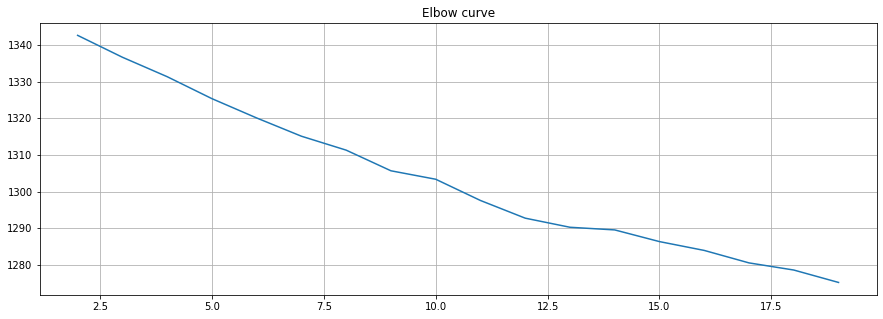

In [99]:
distorsions = []
k_range = 20
for k in range(2, k_range):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200)
    kmeans.fit_predict(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, k_range), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

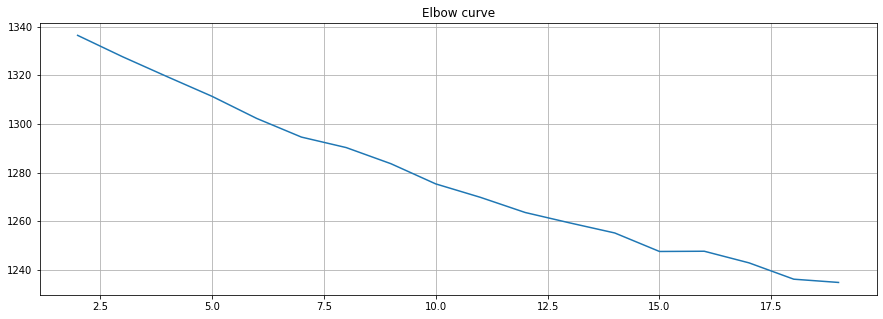

In [101]:
distorsions = []
k_range = 20
for k in range(2, k_range):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200)
    kmeans.fit_predict(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, k_range), distorsions)
plt.grid(True)
plt.title('Elbow curve')

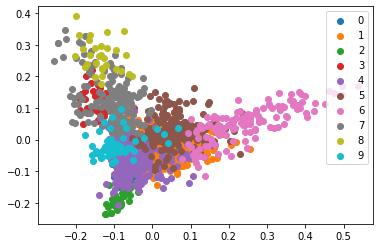

In [102]:
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
nos_trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [103]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(nos_trafficking_df["K means cluster"].value_counts())

Top terms per cluster:
                0            1                  2                3  \
0      gevangenis   verdachten            wietpas         bouterse   
1      gevangenen    rechtbank        coffeeshops         suriname   
2   gedetineerden         geld         maastricht       surinaamse   
3   gevangenissen       mannen          invoering             dino   
4     smokkelwaar         zaak       burgemeester        president   
5       telefoons    criminele           gemeente             desi   
6          binnen  veroordeeld  coffeeshophouders         santokhi   
7      inrichting         auto         coffeeshop       paramaribo   
8    inrichtingen          cel           overlast             zoon   
9         spullen       beslag      buitenlanders      amerikaanse   
10       bewakers     verdacht          gemeenten         regering   
11      gevangene  organisatie          toeristen      veroordeeld   
12       zaanstad     advocaat          opstelten     verkiezingen 

C:\Users\casbe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 